# Using factory functions in `hssm.wfpt` and `hssm.wfpt.lan` modules

We have designed HSSM to be flexible. The users can use arbitrary log-likelihood functions that take arbitrary numbers of parameters with HSSM. The functions do not have to be LANs. Nor do they have to be differentiable (although differentiable likelihood functions are desirable for use with NUTS samplers). This notebook demonstrates how to use the WFPT class factories to generate arbitrary `pm.Distribution` classes for use with either PyMC or Bambi.

In [1]:
import pytensor
import pytensor.tensor as pt
import arviz as az
import jax
import numpy as np
import pymc as pm
from pymc import sampling_jax

# WFPT and LAN are two factory classes
from hssm import wfpt
from hssm.wfpt import lan
import ssms.basic_simulators

## Using Base WFPT class (The analytical solution of the WFPT likelihood function)

Please note that the analytical solution of the WFPT likelihood function follows Navarro & Fuss (2009). The `a` in this solution is defined on `0, inf`, while the `SSMS` package defines `a` on `-inf, inf`. Therefore, the MAP estimate of `a` will be twice the true value.

Please note that the order in which the list of parameters are defined matter. When estimating the parameters using `PyMC`, parameters need to be passed exactly the same order in which they are defined in `list_params` here.

In [2]:
WFPT_base = wfpt.WFPT

In [3]:
# Simulate some data
v_true, a_true, z_true, t_true = [0.5, 1.5, 0.5, 0.5]
obs_angle = ssms.basic_simulators.simulator(
    [v_true, a_true, z_true, t_true], model="ddm", n_samples=1000
)

The dataset passed to the model should always include two columns:
- rts (responce rates)
- choices 

In [4]:
obs = np.column_stack([obs_angle["rts"][:, 0], obs_angle["choices"][:, 0]])
obs

array([[ 1.09899592,  1.        ],
       [ 2.58403134,  1.        ],
       [ 1.10099578, -1.        ],
       ...,
       [ 3.47596669,  1.        ],
       [ 1.70800042,  1.        ],
       [ 2.89000916,  1.        ]])

In [5]:
pytensor.config.floatX = "float32"

with pm.Model() as m_angle:
    v = pm.Uniform("v", -3.0, 3.0)
    sv = 0
    a = pm.Uniform("a", 0.0, 1.0)
    z = pm.Uniform("z", 0.1, 0.9)
    t = pm.Uniform("t", 0.0, 1.0)

    rt = WFPT_base(
        name="rt",
        v=v,
        sv=sv,
        a=a,
        z=z,
        t=t,
        observed=obs,
    )

    # setting mp_ctx to "forkserver" fixes parallel sampling on M1 Macs
    trace_angle_ddm_base = pm.sample(cores=2, draws=500, tune=500, mp_ctx="forkserver")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v, a, z, t]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 12 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: title={'center': 'v'}>, <Axes: title={'center': 'v'}>],
       [<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'z'}>, <Axes: title={'center': 'z'}>],
       [<Axes: title={'center': 't'}>, <Axes: title={'center': 't'}>]],
      dtype=object)

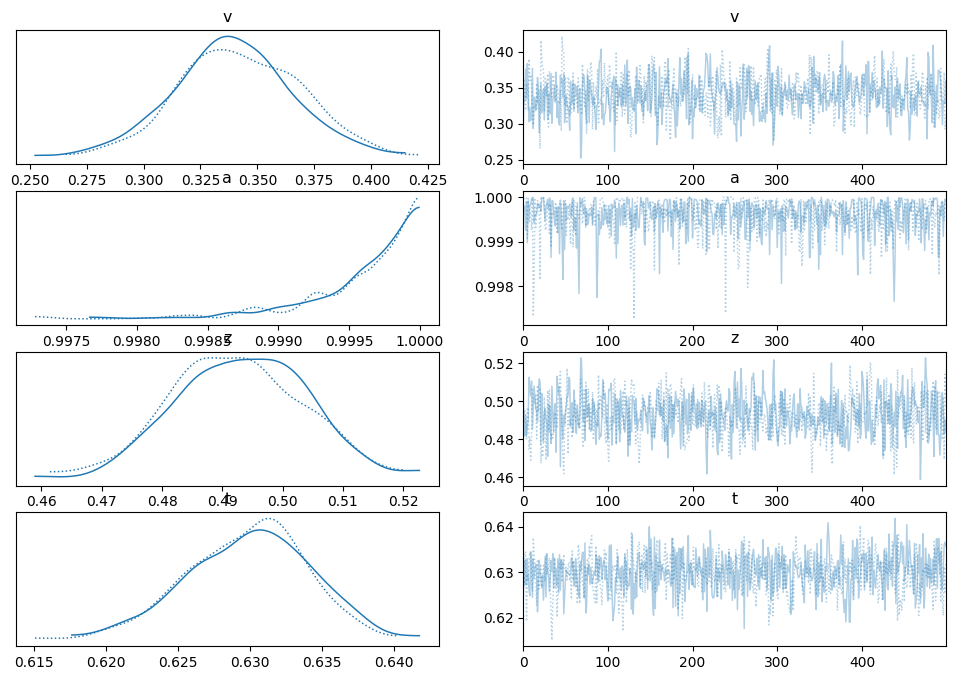

In [6]:
az.plot_trace(trace_angle_ddm_base)

## Using the `lan` factory functions for LAN related functionalities

The lan module has factory methods that produce lan-related log-likelihoods using either `pytensor` or `jax` backend.

### LAN using the JAX backend:

`lan.make_jax_logp_from_onnx` takes an onnx model or the path to it and a number of parameters and produces 3 jax functions: one for the log-likelihood, one for the gradient of the log-likelihood, and one log-likelihood that is not jitted (so it can be unwrapped during JAX sampling).

#### Making JAX LAN functions from onnx models:

Data simulation for LAN class should have different parameters from WFPT base class. 

In [7]:
# Simulate some data
v_true, a_true, z_true, t_true, theta_true = [0.5, 1.5, 0.5, 0.5, 0.3]
obs_angle_lan = ssms.basic_simulators.simulator(
    [v_true, a_true, z_true, t_true, theta_true], model="angle", n_samples=1000
)
obs_lan = np.column_stack([obs_angle_lan["rts"][:, 0], obs_angle_lan["choices"][:, 0]])
obs_lan

array([[ 1.08799601,  1.        ],
       [ 1.20099449,  1.        ],
       [ 1.09799588,  1.        ],
       ...,
       [ 1.1039958 ,  1.        ],
       [ 2.2750268 , -1.        ],
       [ 1.20799446,  1.        ]])

In [8]:
from huggingface_hub import hf_hub_download


ONNX_Model_Path = hf_hub_download(repo_id="Aisulu/hssm_onnx_models", filename="angle.onnx")

In [9]:
logp, logp_grad, logp_nojit = lan.make_jax_logp_funcs_from_onnx(
    ONNX_Model_Path , params_is_reg=[False, False, False, False, False]
)

All these functions take a $n \times 2$ matrix and an arbirary number of parameters and computes the log-likelihood.

#### Wrapping JAX LAN functions in pytensor `Op`s

`lan.make_jax_logp_ops` takes the outputs from `lan.make_jax_logp_funcs_from_onnx` and wrap the 3 JAX functions in pytensor `Op`s. It also takes care of registering the unjitted JAX function with `jax_funcify` so it can be unwrapped in JAX-backend sampling.

In [10]:
pytensor.config.floatX = "float32"
logp_op = lan.make_jax_logp_ops(logp, logp_grad, logp_nojit)
logp_op(np.ones((1000, 2)), *([1.0] * 5))

LANLogpOp.0

#### Create a LAN distribution directly from `wfpt.make_lan_distribution`

`wfpt.make_ssm_distribution` conveniently wraps all steps above and create a `pymc.Distribution`.

In [11]:
LAN_jax = wfpt.make_lan_distribution(
    model=ONNX_Model_Path,
    backend="jax",
    list_params=["v", "a", "z", "t", "theta"],
    params_is_reg=[False, False, False, False, False],
)

In [12]:
LAN_jax.logp(np.ones((1000, 2)), *([1.0] * 5))

LANLogpOp.0

### LAN using the pytensor backend

As an alternative, the onnx model can also be translated directly into pytensor:

In [13]:
logp_pytensor = lan.make_pytensor_logp(ONNX_Model_Path)
logp_pytensor

<function hssm.wfpt.lan.lan.make_pytensor_logp.<locals>.logp(data: 'np.ndarray', *dist_params: 'list[float | ArrayLike]') -> 'ArrayLike'>

In [14]:
logp_pytensor(np.ones((10, 2)), *([2.0] * 5)).eval()

array([-16.285677, -16.285677, -16.285677, -16.285677, -16.285677,
       -16.285677, -16.285677, -16.285677, -16.285677, -16.285677],
      dtype=float32)

#### Create a LAN distribution directly from `wfpt.make_lan_distribution`

When `backend` is not set or to `"pytensor"`, `wfpt.make_lan_distribution` will make a log-likelihood function with aesara and make a `pymc.Distribution` with pytensor backend.

In [15]:
LAN_pytensor = wfpt.make_lan_distribution(
    model=ONNX_Model_Path,
    backend="pytensor",
    list_params=["v", "a", "z", "t", "theta"],
)

### Create arbitrary WFPT distributions

The `wfpt` module provides a general `make_distribution` class method to generate an arbitrary `pymc.Distribution` from user-supplied log-likelihood functions and `RandomVariable` `Op`s.

```python
arbitrary_distribution = wfpt.make_distribution(
    loglike=some_likelihood_func,
    rv=some_RandomVariable_Op,
    list_params=["v", "a", "z", "t", "theta"] # A list of str specifying the names and order of the parameters
)
```

## Sampling from arbitrary LAN distributions

The class produced by the `make_*` functions can then be used for sampling with `PyMC`

#### Sampling with PyMC from LAN distribution with JAX backend

In [16]:
pytensor.config.floatX = "float32"

with pm.Model() as model_jax:
    v = pm.Uniform("v", -3.0, 3.0)
    a = pm.Uniform("a", 0.3, 2.5)
    z = pm.Uniform("z", 0.1, 0.9)
    t = pm.Uniform("t", 0.0, 2.0)
    theta = pm.Uniform("theta", 0.1, 1.2)

    rt = LAN_jax(
        name="rt",
        v=v,
        a=a,
        z=z,
        t=t,
        theta=theta,
        observed=obs_lan,
    )

    # mp_ctx fixes parallel sampling on M1 Macs
    trace_ddm_nuts_jax_wrapped = pm.sample(
        cores=2, draws=500, tune=500, mp_ctx="forkserver"
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v, a, z, t, theta]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 38 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: title={'center': 'v'}>, <Axes: title={'center': 'v'}>],
       [<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'z'}>, <Axes: title={'center': 'z'}>],
       [<Axes: title={'center': 't'}>, <Axes: title={'center': 't'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

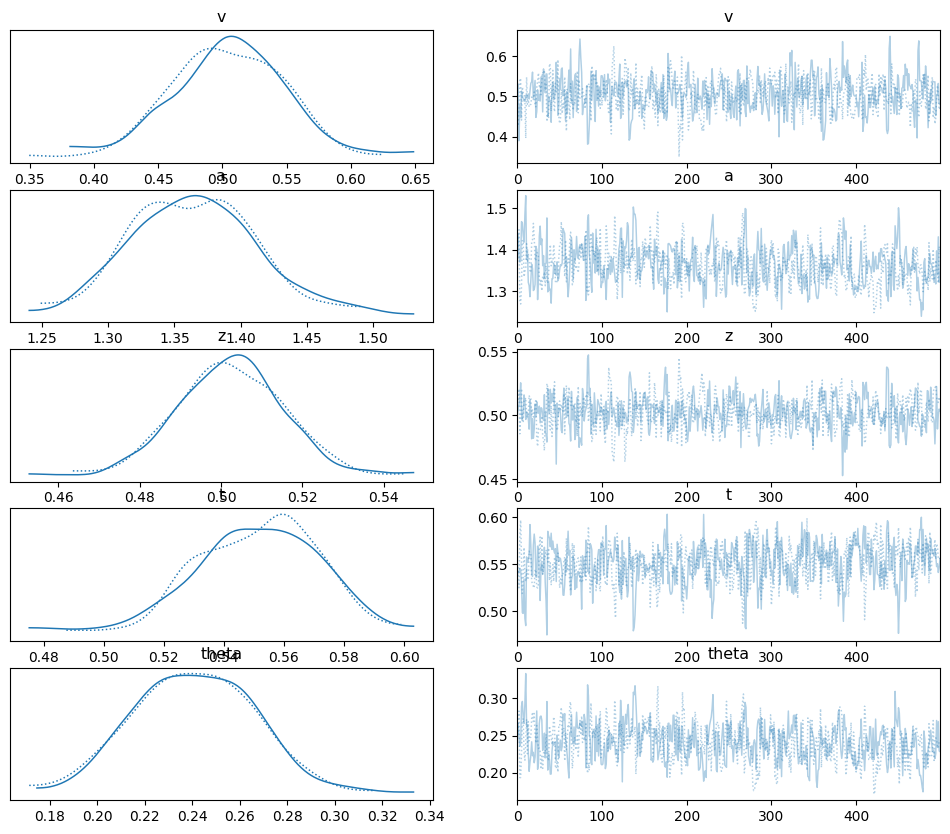

In [17]:
az.plot_trace(trace_ddm_nuts_jax_wrapped)

#### Sampling with JAX and numpyro from LAN distribution with JAX backend

In [56]:
# This forces float32 in jax
from jax.config import config

config.update("jax_enable_x64", False)

with pm.Model() as model_jax_numpyro:
    v = pm.Uniform("v", -3.0, 3.0)
    a = pm.Uniform("a", 0.3, 2.5)
    z = pm.Uniform("z", 0.1, 0.9)
    t = pm.Uniform("t", 0.0, 2.0)
    theta = pm.Uniform("theta", 0.1, 1.2)

    rt = LAN_jax(
        name="rt",
        v=v,
        a=a,
        z=z,
        t=t,
        theta=theta,
        observed=obs_lan,
    )

    # No need to fix parallel sampling on M1 Macs
    trace_ddm_nuts_jax_numpyro = pm.sampling_jax.sample_numpyro_nuts(
        chains=2, draws=500, tune=500, chain_method="parallel"
    )

array([[<AxesSubplot: title={'center': 'v'}>,
        <AxesSubplot: title={'center': 'v'}>],
       [<AxesSubplot: title={'center': 'a'}>,
        <AxesSubplot: title={'center': 'a'}>],
       [<AxesSubplot: title={'center': 'z'}>,
        <AxesSubplot: title={'center': 'z'}>],
       [<AxesSubplot: title={'center': 't'}>,
        <AxesSubplot: title={'center': 't'}>],
       [<AxesSubplot: title={'center': 'theta'}>,
        <AxesSubplot: title={'center': 'theta'}>]], dtype=object)

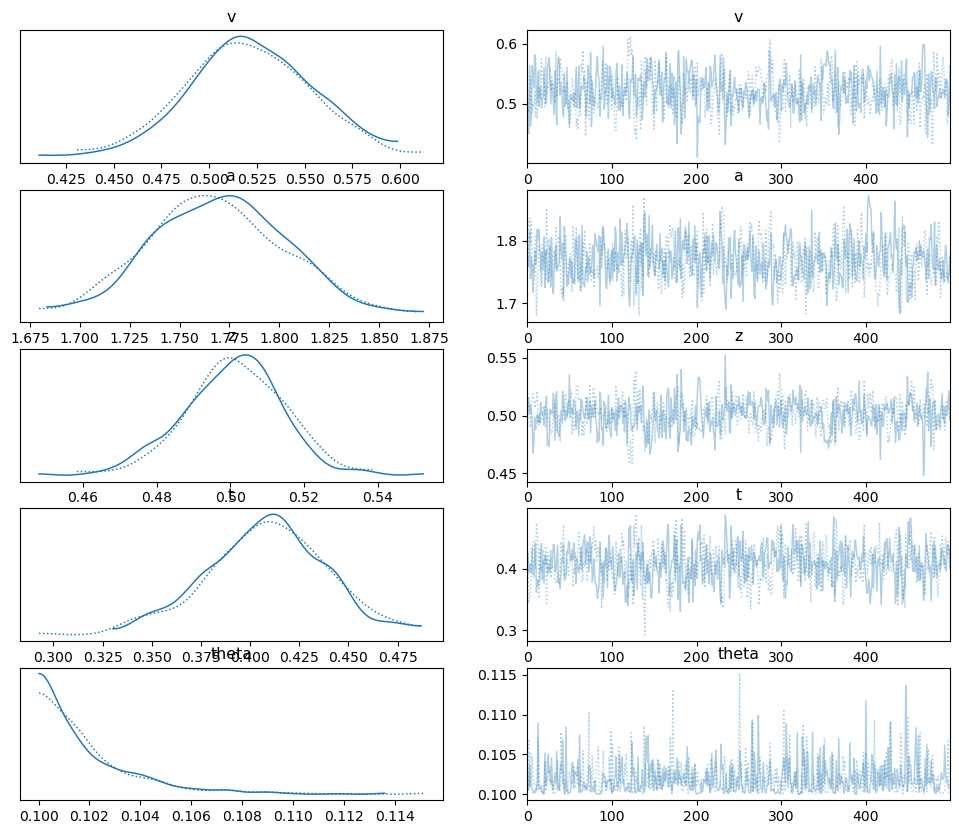

In [25]:
az.plot_trace(trace_ddm_nuts_jax_numpyro)

#### Sampling with PyMC from LAN distribution with pytensor backend

In [40]:
with pm.Model() as model_pytensor:
    v = pm.Uniform("v", -3.0, 3.0)
    a = pm.Uniform("a", 0.3, 2.5)
    z = pm.Uniform("z", 0.1, 0.9)
    t = pm.Uniform("t", 0.0, 2.0)
    theta = pm.Uniform("theta", 0.1, 1.2)

    rt = LAN_pytensor(
        name="rt",
        v=v,
        a=a,
        z=z,
        t=t,
        theta=theta,
        observed=obs_lan,
    )

    trace_ddm_nuts_pytensor = pm.sample(
        cores=2, draws=500, tune=500, mp_ctx="forkserver"
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v, a, z, t, theta]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 39 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: title={'center': 'v'}>, <Axes: title={'center': 'v'}>],
       [<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'z'}>, <Axes: title={'center': 'z'}>],
       [<Axes: title={'center': 't'}>, <Axes: title={'center': 't'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

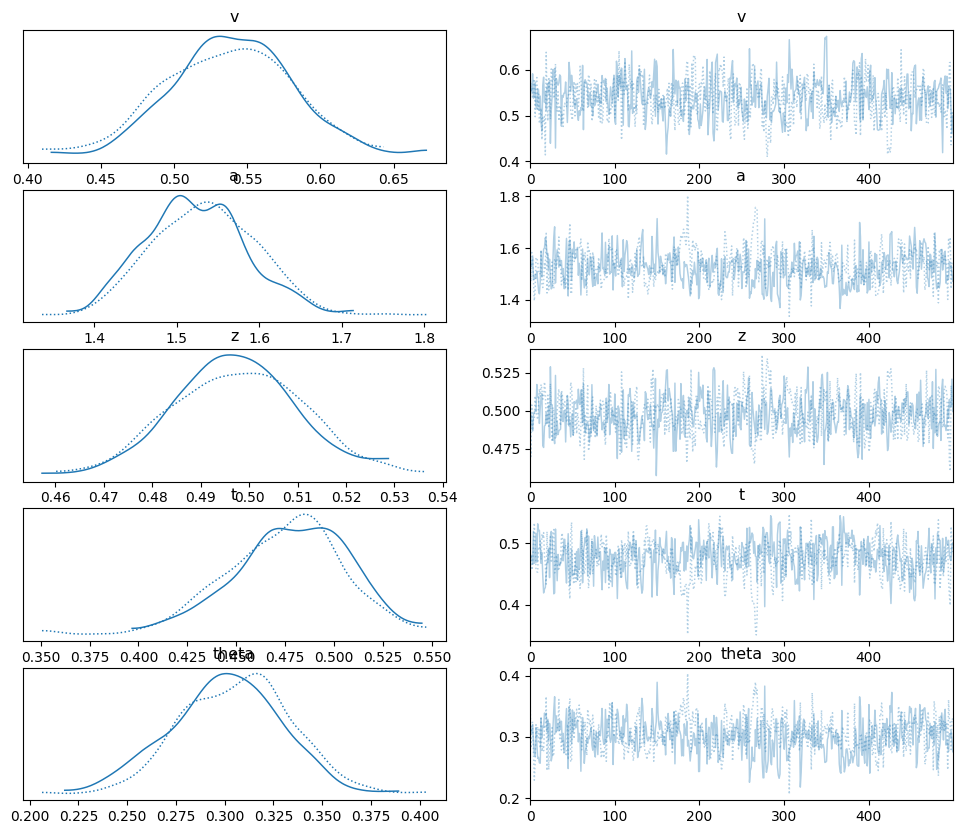

In [45]:
az.plot_trace(trace_ddm_nuts_pytensor)

#### Sampling with JAX and numpyro from LAN distribution with pytensor backend

In [28]:
with pm.Model() as model_pytensor_numpyro:
    v = pm.Uniform("v", -3.0, 3.0)
    a = pm.Uniform("a", 0.3, 2.5)
    z = pm.Uniform("z", 0.1, 0.9)
    t = pm.Uniform("t", 0.0, 2.0)
    theta = pm.Uniform("theta", 0.1, 1.2)

    rt = LAN_pytensor(
        name="rt",
        v=v,
        a=a,
        z=z,
        t=t,
        theta=theta,
        observed=obs_lan,
    )

    trace_ddm_nuts_pytensor_numpyro = pm.sampling_jax.sample_numpyro_nuts(
        chains=2, draws=500, tune=500, chain_method="parallel"
    )

Compiling...
Compilation time =  0:00:00.768996
Sampling...


/Users/aomar7/opt/anaconda3/lib/python3.9/site-packages/pytensor/link/jax/dispatch/elemwise.py:35: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jax_op(x, axis=axis).astype(acc_dtype)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Sampling time =  0:00:28.716055
Transforming variables...
Transformation time =  0:00:00.053170


array([[<AxesSubplot: title={'center': 'v'}>,
        <AxesSubplot: title={'center': 'v'}>],
       [<AxesSubplot: title={'center': 'a'}>,
        <AxesSubplot: title={'center': 'a'}>],
       [<AxesSubplot: title={'center': 'z'}>,
        <AxesSubplot: title={'center': 'z'}>],
       [<AxesSubplot: title={'center': 't'}>,
        <AxesSubplot: title={'center': 't'}>],
       [<AxesSubplot: title={'center': 'theta'}>,
        <AxesSubplot: title={'center': 'theta'}>]], dtype=object)

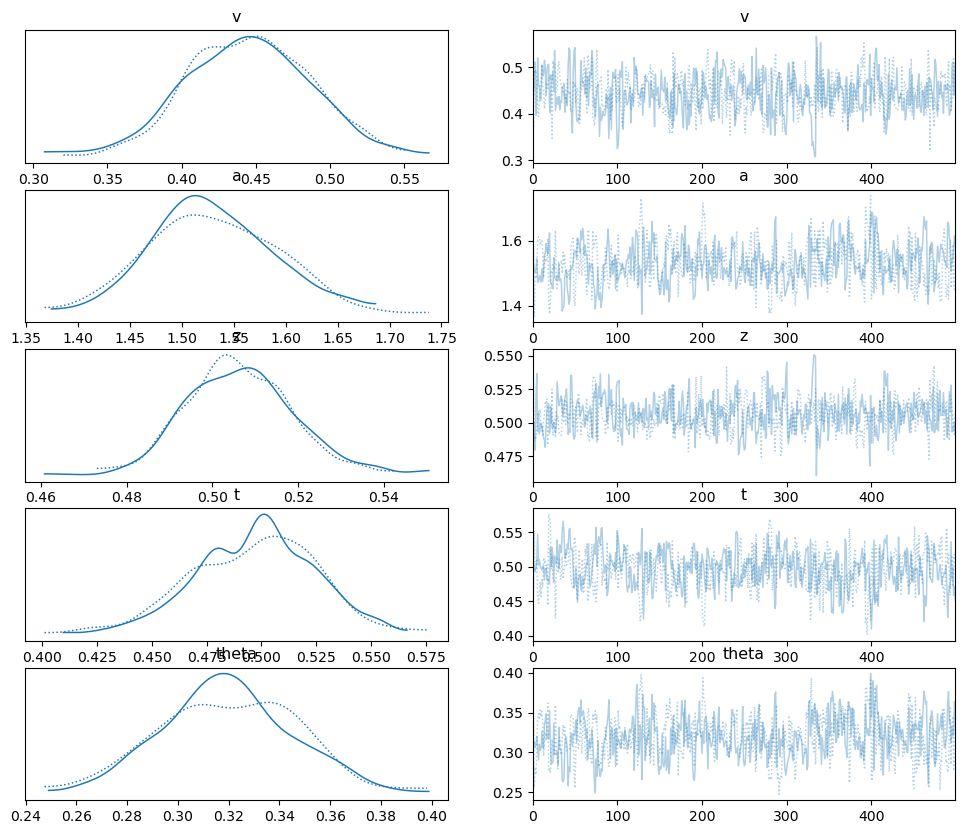

In [29]:
az.plot_trace(trace_ddm_nuts_pytensor_numpyro)